#1

##Pipe

###e -> a -> l



P(l) != P(l|e)
La probabilidad que llamen vs la probabilidad que llamen dado que entraron


La alarma se activa cuando alguien entra. Si la alarma se activa la dueña recibe una llamada.
Sin embargo, la probabilidad de que llamen (a secas) es mas baja.
Va a haber flujo de inferencia

P(l|a) = P(l|e,a)


La probabilidad de que llamen dado que sonó la alarma vs la probabilidad de que llamen dado que entraron y sonó la alrma


Si entran, suena la alarma entonces no hay información nueva. El flujo se cierra.


###l <- a <- t

P(t) != P(t|l)


La probabilidad del terremoto vs la probabilidad del terremoto dado que llamaron


Si hay un terremoto, llaman entonces aumenta la probabilidad de que haya habido un terremoto si llamaron con respecto a que haya habido un terremoto (a secas). Va a haber flujo de inferencia

P(t|a) = P(t|a,l)

La probabilidad de que haya un terremoto dado que sono la alarma vs la probabilidad que haya habido un terremoto dado que son la alarma y llamaron

El flujo se cierra porque si suena la alarma, llaman entonces no aporta información nueva

##Fork

###a <- t -> r

P(r) != P(r|a)


La probabilidad que se hable en las redes vs la probabilidad que se hable en las redes dado que sono la alarma.


El flujo permanece abierto porque si suena la alarma puede ser porque hubo un terremoto entonces se habla en las redes lo cual no es la mismo que la probabilidad que se hable en las redes a secas

P(r|t) = P(r|t,a)

La probabilidad que se hable en las redes dado que hubo un terremoto vs la probablidad que se hable en las redes dado que un terremoto y sono la alarma

El flujo se cierra porque si hay un terremoto, sonará la alarma entonces no aporta información

##Collider

###e -> a <- t
###(a tambien apunta a l)

P(t) = P(t|e)

La probablidad de que haya un terremoto dado que entraron vs la probabilidad de que haya un terremoto

El flujo se cierra porque que hayan entrado no va a cambiar la probabilidad de que haya un terremoto

P(t|a) != P(t|e,a)

La probabilidad de que haya un terremoto dado que sono la alarma vs la probabilidad de que haya un terremoto

El flujo permanece abierto porque si entraron, suena la alarma entonces no aporta información nueva

P(t|l) != P(t|e,l)

La probabilidad de que haya un terremoto dado que llamaron vs la probabilidad de que haya un terremoto dado que llamaron y entraron

El flujo permanece abierto porque si entran, llaman entonces no se aporta información nueva

In [9]:
# -*- coding: utf-8 -*-
"""
   TrueskillThroughTime.py
   ~~~~~~~~~~~~~~~~~~~~~~~~~~
   :copyright: (c) 2019-2024 by Gustavo Landfried.
   :license: BSD, see LICENSE for more details.
"""

import math;
inf = math.inf
sqrt2 = math.sqrt(2); sqrt2pi = math.sqrt(2 * math.pi)
from scipy.stats import norm
from scipy.stats import truncnorm

__all__ = ['MU', 'SIGMA', 'Gaussian', 'N01', 'N00', 'Ninf', 'Nms']

MU = 0.0
SIGMA = 6
PI = SIGMA**-2
TAU = PI * MU



class Gaussian(object):
    #
    # Constructor
    def __init__(self,mu=MU, sigma=SIGMA):
        if sigma >= 0.0:
            self.mu, self.sigma = mu, sigma
        else:
            raise ValueError(" sigma should be greater than 0 ")
    #
    # Iterador
    def __iter__(self):
        return iter((self.mu, self.sigma))
    #
    # Print
    def __repr__(self):
        return 'N(mu={:.3f}, sigma={:.3f})'.format(self.mu, self.sigma)
    #
    # pi = 1/sigma^2
    @property
    def pi(self):
        if self.sigma > 0.0:
            return(1/self.sigma**2)
        else:
            return inf
    #
    # tau = mu*pi
    @property
    def tau(self):
        if self.sigma > 0.0:
            return(self.mu*self.pi)
        else:
            return 0
    #
    # N > 0
    def __gt__(self, threshold):
        # Gaussiana truncada: N > 0.
        mu, sigma = self
        truncated_norm = truncnorm(
            (threshold - mu) / sigma, inf, loc=mu, scale=sigma)
        # Devolver la Gaussiana con misma media y desvío
        return(Gaussian(truncated_norm.mean(), truncated_norm.std()))
    #
    # N >= 0
    def __ge__(self, threshold):
        return self.__gt__(threshold)
    #
    # N + M
    def __add__(self, M):
        _mu = self.mu + M.mu
        _sigma = math.sqrt(self.sigma**2 + M.sigma**2)
        return(Gaussian(_mu, _sigma))
    #
    # N - M
    def __sub__(self, M):
        _mu = self.mu - M.mu
        _sigma = math.sqrt(self.sigma**2 + M.sigma**2)
        return(Gaussian(_mu, _sigma))
    #
    # N * M
    def __mul__(self, M):
        if M.pi == 0:
            return self
        if self.pi == 0:
            return M
        _pi = (self.pi + M.pi)
        _sigma = _pi**-(1/2)
        _mu = (self.tau + M.tau)/_pi
        return(Gaussian(_mu,_sigma))
    def __rmul__(self, other):
        return self.__mul__(other)
    #
    # N / M
    def __truediv__(self, M):
        _pi = self.pi - M.pi
        _sigma = _pi**-(1/2)
        _mu = (self.tau - M.tau)/_pi
        return(Gaussian(_mu,_sigma))
    # Delta
    def delta(self, M):
        return abs(self.mu - M.mu) , abs(self.sigma - M.sigma)
    #
    def cdf(self, x):
        return norm(*self).cdf(x)
    # IsApprox
    def isapprox(self, M, tol=1e-4):
        return (abs(self.mu - M.mu) < tol) and (abs(self.sigma - M.sigma) < tol)


def suma(Ns):
    res = Gaussian(0,0) # neutro de la suma
    for N in Ns:
        res += res + N
    return(res)



N01 = Gaussian(0,1)
N00 = Gaussian(0,0)
Ninf = Gaussian(0,inf)
Nms = Gaussian(MU, SIGMA)

In [6]:
#pip install trueskillthroughtime

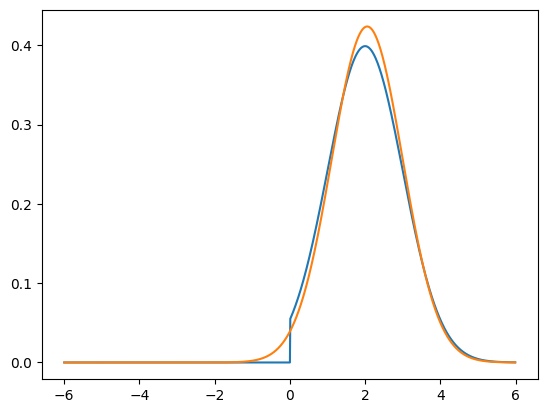

In [10]:
# -*- coding: utf-8 -*-
#from Gaussiana import *

#habilidades a priori de cada jugador
s1 = Gaussian(); s2 = Gaussian(); s3 = Gaussian(); s4 = Gaussian()
o = Gaussian(0, 1) # ruido

#desempeño individual (habilidad + ruido)
p1 = s1 + o; p2 = s2 + o; p3 = s3 + o; p4 = s4 + o

#desempeño del equipo
ta = p1 + p2; tb = p3 + p4 #priors

d = ta - tb
d_approx = d > 0

lh_d = d_approx / d

lh_ta = lh_d + tb

lh_p1 = lh_ta - p2

lh_s1 = lh_p1 - o

posterior_s1 = s1 * lh_s1

# Vamos a testear nuestro resultado con el paquete público.
import trueskillthroughtime as ttt

s1 = ttt.Gaussian(); s2 = ttt.Gaussian(); s3 = ttt.Gaussian(); s4 = ttt.Gaussian()
o = ttt.Gaussian(0, 1) # ruido
p1 = s1 + o; p2 = s2 + o; p3 = s3 + o; p4 = s4 + o
ta = p1 + p2; tb = p3 + p4
d = ta - tb
lf_d = ttt.approx(d, margin=0, tie=False)/d
lh_ta = lh_d + tb
lh_p1 = lh_ta - p2
lh_s1 = lh_p1 - o
posterior_s1_ttt = s1 * lh_s1
assert posterior_s1_ttt.isapprox(posterior_s1)



import numpy as np
from matplotlib import pyplot as plt
x_grid = np.arange(-6,6,0.01)
plt.plot(x_grid, norm(*Gaussian(2,1)).pdf(x_grid) * (x_grid>0)  )
plt.plot(x_grid, norm(*(Gaussian(2,1) > 0)).pdf(x_grid)  )
plt.show()
### N(mu=2.055, sigma=0.942)

In [20]:
BETA = 1.0 # El desvío estándar del desempeño: N(desempeño | mu=habilidad, sd=BETA).

class Evento(object):
    #
    # Constructor
    def __init__(self, equipos):
        # Ejemplo:
        # equipos = [ [priorA, priorB], [priorC]  ]
        # donde el el orden indica qué equipo ganó.
        self.equipos = equipos
    #
    # Representación
    def __repr__(self):
        return f'{self.equipos}'
    #
    @property
    def desempeño_individuos(self):
        # Genera todos los desempeños sumando ruido a las habilidades
        res = []
        ruido = Gaussian(0,BETA)
        for equipo in self.equipos:
            res.append([]) # Contenedor de equipo
            for habilidad in equipo:
                res[-1].append(habilidad + ruido)
        return(res)
    #
    @property
    def desempeño_equipos(self):
        # Suma de los desempeños individuales
        res = []
        for equipo in self.desempeño_individuos:
        # ta = sum(pi) para cada equipo
            sumo = suma(equipo)
            res.append(sumo)
        return res
    #
    @property
    def diferencia_equipos(self):
        print(self.desempeño_equipos)
        ta, tb = self.desempeño_equipos
        d = ta - tb
        return d

    #
    @property
    def marginal_diferencia(self):
        # P(diferencia, resultado) = P(diferencia) > 0
        d = self.diferencia_equipos
        distribucion = Gaussian(mu=d, sigma=BETA)
        e = 1.0 - distribucion.cdf(0)
        return e
    #
    @property
    def likelihood_diferencia(self):
        d = self.diferencia_equipos
        # Capaz en vez de d tenga que usar Gaussian(d.mu, BETA) PREGUNTAR igual d ya es una Gaussiana
        pd_gana = d > 0 # Es lo que esta en la practica pero capaz le falta algo
        likelihood = pd_gana / d
        return likelihood
    #
    @property
    def likelihood_equipos(self):
        # I(d = ta - tb) Diferencia entre los desempeños de los equipos
        # ta = tb + d; tb = ta - d
        d = self.likelihood_diferencia
        ta, tb = self.desempeño_equipos
        lh_a = d + tb
        lh_b = d - ta
        return [lh_a , lh_b]

    #
    @property
    def likelihood_desempeño(self):
        evento = self
        #
        desempeño_individuos = evento.desempeño_individuos
        likelihood_equipos = evento.likelihood_equipos
        #
        res = []
        for e in range(len(evento.equipos)):
            res.append([])
            for i in range(len(evento.equipos[e])):
                # te = p1 + p2 + p3
                #        <=>
                # p1 = te - (p2 + p3)
                te = likelihood_equipos[e]
                equipo_sin_i = suma(desempeño_individuos[e]) - desempeño_individuos[e][i] # No usar sum(), usar suma()
                likelihood_individuo = te - equipo_sin_i
                res[-1].append(likelihood_individuo)
        return res

    #
    @property
    def likelihood_habilidad(self):
        res = []
        ruido = Gaussian(0,BETA)
        for equipo in self.likelihood_desempeño:
            res.append([])
            for lh_p in equipo:
                lh_s = lh_p - ruido
                res[-1].append(lh_s)
        return res
    #
    @property
    def posterior(self):
        likelihood = self.likelihood_habilidad
        prior = self.equipos
        #
        res = []
        for e in range(len(prior)):
            res.append([])
            for i in range(len(prior[e])):
              posterior_s = prior[e][i] * likelihood[e][i]
              res[-1].append(posterior_s)
        return res


priorA = Gaussian(3,1)
priorB = Gaussian(2,1)
priorC = Gaussian(6,1)
Equipo1, Equipo2 = Evento([ [priorA, priorB], [priorC]]).posterior
#
print("Para el Equipo 1 es" , Equipo1) # Me da re distinto PREGUNTAR
#[N(mu=3.439, sigma=0.938), N(mu=2.439, sigma=0.938)]
print("Para el Equipo 2 es" , Equipo2) # Me da un poco menos distinto
#[N(mu=5.561, sigma=0.938)]

#

#import trueskillthroughtime as ttt
priorA = ttt.Player(ttt.Gaussian(3,1))
priorB = ttt.Player(ttt.Gaussian(2,1))
priorC = ttt.Player(ttt.Gaussian(6,1))
Equipo1, Equipo2 = ttt.Game([ [priorA, priorB], [priorC]]).posteriors()
#
print(Equipo1)
#[N(mu=3.439, sigma=0.938), N(mu=2.439, sigma=0.938)]
print(Equipo2)
#[N(mu=5.561, sigma=0.938)]


[N(mu=8.000, sigma=2.449), N(mu=6.000, sigma=1.414)]
Para el Equipo 1 es [N(mu=3.118, sigma=0.977), N(mu=2.118, sigma=0.977)]
Para el Equipo 2 es [N(mu=5.561, sigma=0.977)]
[N(mu=3.439, sigma=0.938), N(mu=2.439, sigma=0.938)]
[N(mu=5.561, sigma=0.938)]
